In [1]:
!pip install mdptoolbox-hiive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import hiive.mdptoolbox.example
import time

In [2]:
seed = 7
ENV_DIM = 10
ENV_SIZE = ENV_DIM * ENV_DIM  # square board
ACTIONS = 4
MAX_MOVES = 1000
FROZN = '-'
HOLE = '0'
GOAL = 'G'
np.random.seed(seed)
pct_frozen = 0.9
env = [FROZN if np.random.random() < pct_frozen else HOLE for _ in range(ENV_SIZE)]
env[-1] = GOAL
print(' ' * 6 + f'Map {seed}')
def to_char(value):
    if value == HOLE:
        return '●'
    if value == GOAL:
        return '⨂'
    return value
for i in range(0, len(env), ENV_DIM):
    print(' '.join(map(to_char, env[i:i+ENV_DIM])))

      Map 7
- - - - ● - - - - -
- - - - - ● - - ● -
- ● - - ● - - - - -
- - - - - - - - - -
- - - - - - - ● - -
- - - - - - - - - -
● - - - - - ● ● - -
- - - - - - - - - -
- - - - - - - - - -
- ● - - - - - - - ⨂


In [3]:
target_prob = 0.7
slip_prob = 0.15
assert target_prob + slip_prob + slip_prob == 1

def move(direction, from_state):
    if direction == 0:
        if from_state < ENV_DIM or env[from_state] == HOLE:
            return from_state
        else:
            return from_state - ENV_DIM
    if direction == 1:
        if from_state % ENV_DIM == ENV_DIM - 1 or env[from_state] == HOLE:
            return from_state
        else:
            return from_state + 1
    if direction == 2:
        if from_state // ENV_DIM == ENV_DIM - 1 or env[from_state] == HOLE:
            return from_state
        else:
            return from_state + ENV_DIM
    if direction == 3:
        if from_state % ENV_DIM == 0 or env[from_state] == HOLE:
            return from_state
        else:
            return from_state - 1
    raise Exception(f'Unknown direction: {direction}')

    
def calc_s_prime(a, s):
    result = [0] * ENV_SIZE
    
    intended = move(a, s)
    result[intended] += target_prob
    
    slip_left = move((a - 1) % ACTIONS, s)
    result[slip_left] += slip_prob
    
    slip_right = move((a + 1) % ACTIONS, s)
    result[slip_right] += slip_prob
    
    assert sum(result) == 1
    return result
transitions = np.array([
    [calc_s_prime(a, s) for s in range(ENV_SIZE)]
    for a in range(ACTIONS)
])

def generate_rewards(frozen_reward, hole_reward, goal_reward):
    return np.array([hole_reward if env[i] == HOLE else goal_reward if env[i] == GOAL else frozen_reward
                     for i in range(len(env))])

In [4]:
valid_starts = [i for i in range(ENV_SIZE) if env[i] == FROZN]

def calc_avg_reward(policy, rewards, iterations=100):
    total_rewards = 0
    for start in np.random.choice(valid_starts, iterations):
        total_rewards += get_reward(policy, rewards, start)
    return total_rewards / iterations

def get_reward(policy, rewards, start, verbose=False):
    reward = 0
    curr = start
    move = 0
    while env[curr] == FROZN and move < MAX_MOVES:
        move += 1
        reward += rewards[curr]
        a = policy[curr]
        if verbose:
            print(f'{move} curr {curr} ({env[curr]}) then {symbols[a]} ')
        probs = transitions[a][curr]
        curr = np.random.choice(range(len(probs)), p=probs)
    reward += rewards[curr]
    return reward
symbols = ('↑', '→', '↓', '←')
def to_symbol(x, i):
    if env[i] == HOLE:
        return '●'
    if env[i] == GOAL:
        return '⨂'
    return symbols[x]

def print_policy(policy):
    for i in range(0, len(env), ENV_DIM):
        print(' '.join(to_symbol(policy[i+j], i+j) for j in range(ENV_DIM)))

In [5]:
results_columns = ['iterations', 'avg_reward', 'seconds_elapsed']

def run_mdp(MDP, transitions, rewards, discount, step, verbose=False):
    np.random.seed(seed)
    results = pd.DataFrame(columns=results_columns, dtype=float)
    iters = step
    while True:
        mdp = MDP(transitions, rewards, discount)
        mdp.max_iter = iters
        mdp.run()
        
        policy = mdp.policy
        actual_iters = mdp.iter
        avg_reward = calc_avg_reward(policy, rewards, 500)
        
        results.loc[actual_iters, results_columns] = (actual_iters, avg_reward, mdp.time)
        if verbose:
            print({'iterations': mdp.iter, 'seconds elapsed': mdp.time, 'avg reward': avg_reward})
        
        if actual_iters < iters:
            # we have converged!
            break
        iters += step
    return policy, results

def print_mismatches(p0, p1):
    assert len(p0) == len(p1)
    mismatches = [(i, p0[i], p1[i])
                  for i in range(len(p0))
                  if p0[i] != p1[i] and env[i] != GOAL]
    for i, v, p in mismatches:
            print(f"mismatch at {i} (row {i // ENV_DIM}, col {i % ENV_DIM})")
            print(f"  p0 gave {to_symbol(v, i)} and p1 gave {to_symbol(p, i)}")
standard_rewards = generate_rewards(-0.04, -1, 1)
discount = 0.96
max_iter = 50000

In [6]:
vi = ValueIteration(transitions, standard_rewards, discount)
vi.setVerbose()
arr_vi = vi.run()
print("Value iteration")
print_policy(vi.policy)

 Iteration   Variation
         1    2.000000
         2    1.770240
         3    1.677865
         4    1.593153
         5    1.524806
         6    1.459743
         7    1.400031
         8    1.342839
         9    1.288695
        10    1.236757
        11    1.187135
        12    1.139512
        13    1.093876
        14    1.050070
        15    1.008045
        16    0.967704
        17    0.928987
        18    0.891820
        19    0.856143
        20    0.821895
        21    0.789017
        22    0.757455
        23    0.727157
        24    0.698070
        25    0.670147
        26    0.643341
        27    0.617607
        28    0.592902
        29    0.569186
        30    0.546419
        31    0.524562
        32    0.503580
        33    0.483436
        34    0.464099
        35    0.445535
        36    0.427714
        37    0.410605
        38    0.394181
        39    0.378414
        40    0.363277
        41    0.348746
        42    0.334796
        43 

In [7]:
pi = PolicyIteration(transitions, standard_rewards, discount)
pi.setVerbose()
arr_pi = pi.run()
print("Policy Iteration")
print_policy(pi.policy)

 Iteration   Variation
         1          77
         2          45
         3          42
         4          17
         5          12
         6           9
         7           4
         8           1
         9           0
Iterating stopped, unchanging policy found.
Policy Iteration
↓ → ↓ ← ● → → ↓ ↑ ↓
↓ ↑ ↓ ← ← ● → ← ● →
← ● → ← ● ↓ → → ↓ ↓
↓ ↓ ↓ ↓ ↓ ↓ → ↑ → ↓
→ → ↓ ↓ ↓ ↓ ← ● → ↓
↑ → ↓ ↓ ↓ ← ↑ → → ↓
● → ↓ ↓ ↓ ← ● ● → ↓
↓ → → → → ↓ ↓ ↓ ↓ ↓
→ ↑ → → → → → → → ↓
← ● → → → → → → → ⨂


In [8]:
np.random.seed(0)
ql = QLearning(transitions, standard_rewards, discount, n_iter=max_iter)
ql.setVerbose()
arr_ql = ql.run()
print("QLearning")
print (arr_ql[-1])
print_policy(ql.policy)

QLearning
{'State': 54, 'Action': 1, 'Reward': -0.04, 'Error': 4.04056119777216e-05, 'Time': 4.6762824058532715, 'Alpha': 0.001, 'Epsilon': 0.1, 'Gamma': 0.96, 'Max V': 0.7549701964761182, 'Mean V': -0.09454253418542273, 'Iteration': 50000}
↑ ↑ ← ← ● ← ↑ ↓ → ↑
← ↑ ↓ ↓ ← ● → ↓ ● →
← ● → ↑ ● ← ← ↑ ← ←
↑ ↓ ↓ ↓ ← → ↓ ↓ ← ↑
↓ ↓ ← → → → ← ● ↑ ↑
← → ↓ ← ← ← ↑ ← ↓ ←
● → ↓ ↑ ↑ ← ● ● ← ←
↓ ↑ ↓ ← → → ↓ → ← ↓
↓ ↑ ↓ → ↑ ↑ → ↓ → ↓
← ● ↑ → → ← ← → → ⨂


In [9]:
np.random.seed(0)
ql_r = QLearning(transitions, standard_rewards, discount, n_iter=max_iter)
ql_r.epsilon_min=1
ql_r.alpha_min=1
ql_r.setVerbose()
arr_ql_r = ql_r.run()
print("QLearning_random")
print (arr_ql_r[-1])
print_policy(ql_r.policy)

QLearning_random
{'State': 75, 'Action': 2, 'Reward': -0.04, 'Error': 0.0, 'Time': 4.61161470413208, 'Alpha': 1, 'Epsilon': 1, 'Gamma': 0.96, 'Max V': 24.711514537408927, 'Mean V': 11.683977547033782, 'Iteration': 50000}
→ ↓ → ↑ ● ↑ ↓ ↓ → ↓
↓ ↑ ↓ → ← ● → → ● ↓
↓ ● → ↓ ● → ↑ ↓ → ↓
→ → → ↑ ↓ ← → → → ↓
↑ ↓ → → → ↓ ↓ ● → ↓
→ ↓ ↑ → → ↓ → → → ↓
● ↑ → → ← ↓ ● ● ↓ →
→ → ↑ ↑ → → → ↓ ↓ →
→ → → → → → → ← → →
→ ● → → → ↓ → → → ⨂


In [10]:
print ("VI policy is the same as PI policy: ", vi.policy==pi.policy)
print ("VI policy is the same as QL policy: ", ql.policy==vi.policy)
print ("QL policy is the same as PI policy: ", ql.policy==pi.policy)
print ("QL policy is the same as QL_R policy: ", ql.policy==ql_r.policy)

VI policy is the same as PI policy:  True
VI policy is the same as QL policy:  False
QL policy is the same as PI policy:  False
QL policy is the same as QL_R policy:  False


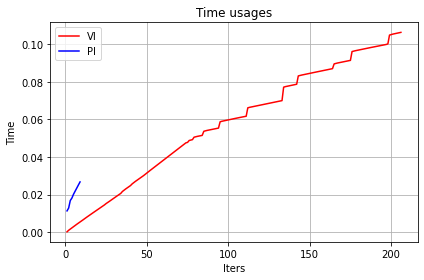

(None, None)

In [11]:
time_vi = []
iter_vi = []
for x in arr_vi:
  time_vi.append(x['Time'])
  iter_vi.append(x['Iteration'])
time_pi = []
iter_pi = []
for x in arr_pi:
  time_pi.append(x['Time'])
  iter_pi.append(x['Iteration'])
plt.grid()
plt.plot(iter_vi, time_vi, color='red', label='VI')
plt.plot(iter_pi, time_pi, color='blue', label='PI')
plt.xlabel('Iters'), plt.ylabel('Time'), plt.legend(loc='best'), plt.title('Time usages')
plt.tight_layout(), plt.show()

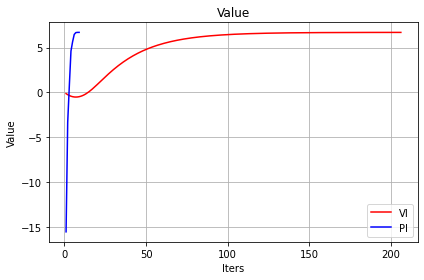

(None, None)

In [12]:
value_vi = []
value_pi = []
for x in arr_vi:
  value_vi.append(x['Mean V'])
for x in arr_pi:
  value_pi.append(x['Mean V'])
plt.grid()
plt.plot(iter_vi, value_vi, color='red', label='VI')
plt.plot(iter_pi, value_pi, color='blue', label='PI')
plt.xlabel('Iters'), plt.ylabel('Value'), plt.legend(loc='best'), plt.title('Value')
plt.tight_layout(), plt.show()

In [14]:
reward = np.zeros(max_iter)
reward_r = np.zeros(max_iter)
error = np.zeros(max_iter)
error_r = np.zeros(max_iter)
iteration = np.arange(1, max_iter+1)
for x in arr_ql:
  for i in range(1, max_iter+1):
    if x['Iteration'] == i:
      error[i-1] = error[i-1]+abs(x['Error'])
      reward[i-1] = reward[i-1]+(x['Reward'])
y = []
y.append(error[0])
for x in arr_ql_r:
  for i in range(1, max_iter+1):
    if x['Iteration'] == i:
      error_r[i-1] = error_r[i-1]+abs(x['Error'])
      reward_r[i-1] = reward_r[i-1]+(x['Reward'])
y_r = []
y_r.append(error_r[0])
for i in range (1, max_iter):
  y.append(abs(error[i]-error[i-1]))
  y_r.append(abs(error_r[i]-error_r[i-1]))

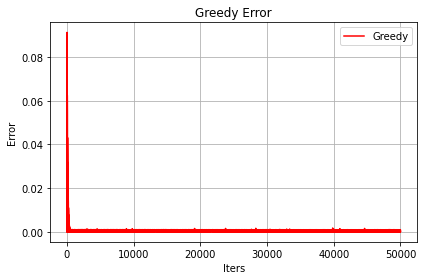

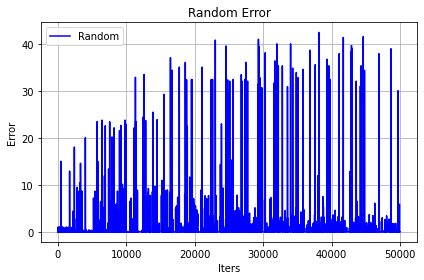

(None, None)

In [15]:
plt.grid()
plt.plot(iteration, y, color='red', label='Greedy')
plt.xlabel("Iters"), plt.ylabel('Error'), plt.legend(loc='best'),plt.title('Greedy Error')
plt.tight_layout(), plt.show()
plt.grid()
plt.plot(iteration, y_r, color='blue', label='Random')
plt.xlabel("Iters"), plt.ylabel('Error'), plt.legend(loc='best'),plt.title('Random Error')
plt.tight_layout(), plt.show()

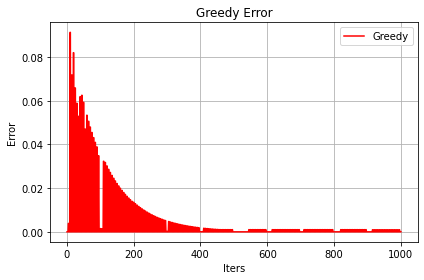

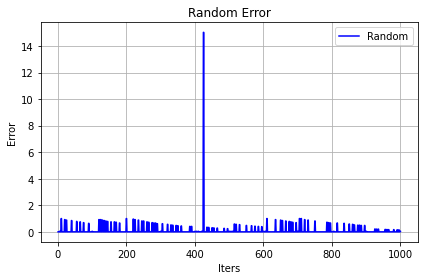

(None, None)

In [16]:
plt.grid()
plt.plot(iteration[:1000], y[:1000], color='red', label='Greedy')
plt.xlabel("Iters"), plt.ylabel('Error'), plt.legend(loc='best'), plt.title('Greedy Error')
plt.tight_layout(), plt.show()
plt.grid()
plt.plot(iteration[:1000], y_r[:1000], color='blue', label='Random')
plt.xlabel("Iters"), plt.ylabel('Error'), plt.legend(loc='best'), plt.title('Random Error')
plt.tight_layout(), plt.show()

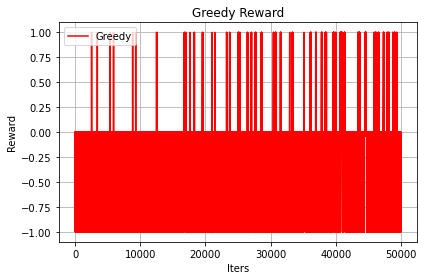

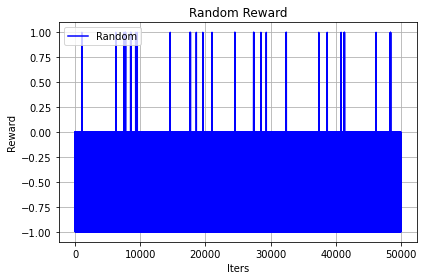

(None, None)

In [17]:
plt.grid()
plt.plot(iteration, reward, color='red', label='Greedy')
plt.xlabel("Iters"), plt.ylabel('Reward'), plt.legend(loc='best'), plt.title('Greedy Reward')
plt.tight_layout(), plt.show()
plt.grid()
plt.plot(iteration, reward_r, color='blue', label='Random' )
plt.xlabel("Iters"), plt.ylabel('Reward'), plt.legend(loc='best'), plt.title('Random Reward')
plt.tight_layout(), plt.show()

In [19]:
print ("QL reach max reward times: ", (reward==1).sum())
print ("QL Random reach max reward times: ", (reward_r==1).sum())

QL reach max reward times:  240
QL Random reach max reward times:  47
